In [8]:
import logging
import time
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, WebDriverException
import pandas as pd
import re

OUTPUT_CSV_PATH = 'Google_flights_040325.csv'
CURRENCY = "USD"
SNAPSHOTS = 1
TTT_RANGE = range(1, 31)
LOS_RANGE = range(1, 6)
ROUTES = [
    ("Paris", "London"),
    ("Paris", "Rome"),
    ("London", "Paris"),
    ("London", "Rome"),
    ("Rome", "London"),
    ("Rome", "Paris")
]
MAX_SEARCHES = 10000
MAX_WORKERS = 15

def configure_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("Google_flights_040325.log"),
            logging.StreamHandler()
        ]
    )

def init_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    try:
        return webdriver.Chrome(options=options)
    except WebDriverException as e:
        logging.error(f"WebDriver error: {e}")
        return None

def generate_dates(ttt, los, snapshot_date):
    departure_date = snapshot_date + timedelta(days=ttt)
    return_date = departure_date + timedelta(days=los)
    return departure_date.strftime('%Y-%m-%d'), return_date.strftime('%Y-%m-%d')

def scrape_flight_data(origin, destination, ttt, los, snapshot_date):
    driver = init_driver()
    if not driver:
        return []

    flight_data = []
    try:
        departure_date, return_date = generate_dates(ttt, los, snapshot_date)
        search_url = f"https://www.google.com/travel/flights?q=Flights%20from%20{origin}%20to%20{destination}" \
                     f"%20on%20{departure_date}%20returning%20on%20{return_date}&curr={CURRENCY}&hl=en-US"
        driver.get(search_url)
        time.sleep(5)

        try:
            view_more_button = driver.find_element(By.XPATH, "//button[@aria-label='View more flights']")
            driver.execute_script("arguments[0].click();", view_more_button)
            time.sleep(3)
        except NoSuchElementException:
            logging.warning(f"No 'View more flights' button found for {origin} → {destination}")

        for _ in range(5):
            driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
            time.sleep(1)

        flights = driver.find_elements(By.CSS_SELECTOR, "li.pIav2d")

        for flight in flights[:100]:
            try:
                flight_text = extract_flight_text(flight)
                parsed_flight = parse_flight_details(flight_text, snapshot_date, origin, destination, ttt, los, departure_date, return_date)
                if parsed_flight:
                    flight_data.append(parsed_flight)
            except Exception as e:
                logging.error(f"Error parsing flight data: {e}")

    except Exception as e:
        logging.error(f"Error during scraping for {origin} → {destination}: {e}")

    finally:
        driver.quit()

    return flight_data

def extract_flight_text(li_element):
    flight_div = li_element.find_element(By.CLASS_NAME, "JMc5Xc")
    return flight_div.get_attribute("aria-label")

def parse_flight_details(flight_text, snapshot_date, origin, destination, ttt, los, departure_date, return_date):
    try:
        price = re.search(r'From (\d+) US dollars', flight_text)
        stops = re.search(r'(\d+ stop|Nonstop)', flight_text)
        airline = re.search(r'with ([\w\s]+)\.', flight_text)
        departure_airport = re.search(r'Leaves (.+?) at', flight_text)
        departure_time = re.search(r'at (\d{1,2}:\d{2} [AP]M)', flight_text)
        arrival_airport = re.search(r'arrives at (.+?) at', flight_text)
        arrival_time = re.search(r'at (\d{1,2}:\d{2} [AP]M) on', flight_text)
        duration = re.search(r'Total duration (\d+ hr \d+ min)', flight_text)
        layover = re.search(r'Layover \(1 of 1\) is a (\d+ hr \d+ min)', flight_text)

        return {
            "Website": "Google flights",
            "Snapshot date": snapshot_date.strftime("%Y-%m-%d"),
            "Airline": airline.group(1) if airline else "N/A",
            "Price": price.group(1) if price else "N/A",
            "TTT": ttt,
            "LOS": los,
            "Origin": origin,
            "Destination": destination,
            "Departure date": departure_date,
            "Departure Airport": departure_airport.group(1) if departure_airport else "N/A",
            "Departure Time": departure_time.group(1) if departure_time else "N/A",
            "Layover": layover.group(1) if layover else "None",
            "Stops": stops.group(1) if stops else "N/A",
            "Return date": return_date,
            "Arrival Airport": arrival_airport.group(1) if arrival_airport else "N/A",
            "Arrival Time": arrival_time.group(1) if arrival_time else "N/A",
            "Duration": duration.group(1) if duration else "N/A",
        }
    
    except Exception as e:
        logging.error(f"Error parsing flight details: {e}")
        return None

def run_scraping(snapshot_dates):
    data = []
    search_count = 0

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = []
        for snapshot_date in snapshot_dates:
            for origin, destination in ROUTES:
                for ttt in TTT_RANGE:
                    for los in LOS_RANGE:
                        if search_count >= MAX_SEARCHES:
                            break
                        futures.append(executor.submit(scrape_flight_data, origin, destination, ttt, los, snapshot_date))
                        search_count += 1
                        logging.info(f"Scheduled search {search_count} of {MAX_SEARCHES}")

        for future in as_completed(futures):
            try:
                flight_data = future.result()
                if flight_data:
                    data.extend(flight_data)
            except Exception as e:
                logging.error(f"Error in future execution: {e}")

    return data

def save_to_csv(data):
    df = pd.DataFrame(data)
    df.to_csv(OUTPUT_CSV_PATH, index=False)
    logging.info(f"Data saved to {OUTPUT_CSV_PATH}")

def main():
    configure_logging()
    snapshot_dates = [datetime.now() + timedelta(days=7 * i) for i in range(SNAPSHOTS)]
    flight_data = run_scraping(snapshot_dates)
    save_to_csv(flight_data)

if __name__ == "__main__":
    main()

2025-03-04 10:26:23,277 - INFO - Scheduled search 1 of 10000
2025-03-04 10:26:23,284 - INFO - Scheduled search 2 of 10000
2025-03-04 10:26:23,285 - INFO - Scheduled search 3 of 10000
2025-03-04 10:26:23,292 - INFO - Scheduled search 4 of 10000
2025-03-04 10:26:23,297 - INFO - Scheduled search 5 of 10000
2025-03-04 10:26:23,303 - INFO - Scheduled search 6 of 10000
2025-03-04 10:26:23,312 - INFO - Scheduled search 7 of 10000
2025-03-04 10:26:23,318 - INFO - Scheduled search 8 of 10000
2025-03-04 10:26:23,321 - INFO - Scheduled search 9 of 10000
2025-03-04 10:26:23,329 - INFO - Scheduled search 10 of 10000
2025-03-04 10:26:23,360 - INFO - Scheduled search 11 of 10000
2025-03-04 10:26:23,371 - INFO - Scheduled search 12 of 10000
2025-03-04 10:26:23,397 - INFO - Scheduled search 13 of 10000
2025-03-04 10:26:23,417 - INFO - Scheduled search 14 of 10000
2025-03-04 10:26:23,443 - INFO - Scheduled search 15 of 10000
2025-03-04 10:26:23,496 - INFO - Scheduled search 16 of 10000
2025-03-04 10:26:

In [25]:
df = pd.read_csv("/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/csv/Google_flights_040325.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89912 entries, 0 to 89911
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Website            89912 non-null  object
 1   Snapshot date      89912 non-null  object
 2   Airline            89541 non-null  object
 3   Price              89912 non-null  int64 
 4   TTT                89912 non-null  int64 
 5   LOS                89912 non-null  int64 
 6   Origin             89912 non-null  object
 7   Destination        89912 non-null  object
 8   Departure date     89912 non-null  object
 9   Departure Airport  89912 non-null  object
 10  Departure Time     89912 non-null  object
 11  Layover            60619 non-null  object
 12  Stops              89912 non-null  object
 13  Return date        89912 non-null  object
 14  Arrival Airport    89912 non-null  object
 15  Arrival Time       89912 non-null  object
 16  Duration           83853 non-null  objec

,Website,Snapshot date,Airline,Price,TTT,LOS,Origin,Destination,Departure date,Departure Airport,Departure Time,Layover,Stops,Return date,Arrival Airport,Arrival Time,Duration
0,Google flights,2025-03-04,easyJet,80,3,5,Paris,London,2025-03-07,Paris Charles de Gaulle Airport,9:55 AM,NaN,Nonstop,2025-03-12,London Luton Airport,9:55 AM,1 hr 25 min
1,Google flights,2025-03-04,easyJet,86,3,5,Paris,London,2025-03-07,Paris Charles de Gaulle Airport,2:30 PM,NaN,Nonstop,2025-03-12,London Luton Airport,2:30 PM,1 hr 15 min
2,Google flights,2025-03-04,easyJet,88,3,5,Paris,London,2025-03-07,Paris Charles de Gaulle Airport,7:20 AM,NaN,Nonstop,2025-03-12,London Gatwick Airport,7:20 AM,1 hr 10 min
3,Google flights,2025-03-04,Vueling,98,3,5,Paris,London,2025-03-07,Paris Orly Airport,12:30 PM,NaN,Nonstop,2025-03-12,London Gatwick Airport,12:30 PM,1 hr 10 min
4,Google flights,2025-03-04,easyJet,86,3,5,Paris,London,2025-03-07,Paris Charles de Gaulle Airport,5:00 PM,NaN,Nonstop,2025-03-12,London Luton Airport,5:00 PM,1 hr 15 min


In [28]:
import pandas as pd
import re

# Count occurrences of "0" in the 'Airline' column
count_zeros = (df['Airline'] == "0").sum()

# Filter out rows where 'Airline' is "0"
df_unclean = df[df['Airline'] != "0"]

# Extract the first airline name before " and "
df_unclean['Airline'] = df_unclean['Airline'].str.split(' and ').str[0]

# Replace NaN values in the 'Airline' column with "0"
df_unclean['Airline'].fillna("0", inplace=True)

# Function to convert duration to hours
def convert_to_hours(duration):
    if pd.isna(duration) or duration == "nan":  # Handle NaN values
        return 0  # Convert NaN to 0
    if isinstance(duration, str):  # Ensure it's a string before regex matching
        match = re.match(r'(\d+) hr(?: (\d+) min)?', duration)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0  # Handle cases where minutes might be missing
            return round(hours + minutes / 60, 2)
    return 0  # If it's not a valid string format, return 0

# Replace NaN values with "0" before applying conversion
df_unclean['Duration'] = df_unclean['Duration'].fillna(0).astype(str).apply(convert_to_hours)
df_unclean['Layover'] = df_unclean['Layover'].fillna(0).astype(str).apply(convert_to_hours)

# Save the cleaned data
df_unclean.to_csv("cleaned_flight_data040325.csv", index=False)
print("Cleaned CSV file has been saved as 'cleaned_flight_data040325.csv'.")


/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_57536/917176887.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_unclean['Airline'].fillna("0", inplace=True)


Cleaned CSV file has been saved as 'cleaned_flight_data040325.csv'.


In [51]:
clean_airline_df= pd.read_csv("/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/GOOGLEFLIGHTMERGE0304.csv")
clean_airline_df.tail(50)

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_57536/1562270904.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_airline_df= pd.read_csv("/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/GOOGLEFLIGHTMERGE0304.csv")


,Website,Snapshot date,Airline,Price,TTT,LOS,Origin,Destination,Departure date,Departure Airport,Departure Time,Layover,Stops,Return date,Arrival Airport,Arrival Time,Duration
177977,Google flights,2025-03-03,easyJet,197,30,5,Rome,Paris,2025-04-02,FCO,5:10 PM,3.33,1,2025-04-07,CDG,5:10 PM,6.25
177978,Google flights,2025-03-03,Vueling,198,30,5,Rome,Paris,2025-04-02,FCO,6:25 AM,9.58,1,2025-04-07,ORY,6:25 AM,13.25
177979,Google flights,2025-03-03,Vueling,198,30,5,Rome,Paris,2025-04-02,FCO,9:05 AM,6.75,1,2025-04-07,ORY,9:05 AM,10.58
177980,Google flights,2025-03-03,Vueling,198,30,5,Rome,Paris,2025-04-02,FCO,2:10 PM,1.83,1,2025-04-07,ORY,2:10 PM,5.50
177981,Google flights,2025-03-03,Vueling,202,30,5,Rome,Paris,2025-04-02,FCO,12:40 PM,3.33,1,2025-04-07,ORY,12:40 PM,0.00
177982,Google flights,2025-03-03,Air France,213,30,5,Rome,Paris,2025-04-02,FCO,6:05 AM,0.00,0,2025-04-07,CDG,6:05 AM,2.25
177983,Google flights,2025-03-03,Air France,213,30,5,Rome,Paris,2025-04-02,FCO,10:00 AM,0.00,0,2025-04-07,CDG,10:00 AM,2.17
177984,Google flights,2025-03-03,Air France,213,30,5,Rome,Paris,2025-04-02,FCO,3:40 PM,0.00,0,2025-04-07,CDG,3:40 PM,2.17
177985,Google flights,2025-03-03,Air France,213,30,5,Rome,Paris,2025-04-02,FCO,4:55 PM,0.00,0,2025-04-07,CDG,4:55 PM,2.17
177986,Google flights,2025-03-03,Air France,213,30,5,Rome,Paris,2025-04-02,FCO,6:25 PM,0.00,0,2025-04-07,CDG,6:25 PM,2.17


In [55]:
def remove_outliers(df):
    grouped = df.groupby(['Origin', 'Destination'])
    rows_to_keep = []
    
    for (origin, destination), group in grouped:
        Q1 = group['Price'].quantile(0.25)
        Q3 = group['Price'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_group = group[(group['Price'] >= lower_bound) & (group['Price'] <= upper_bound)]
        rows_to_keep.append(filtered_group)
    cleaned_df = pd.concat(rows_to_keep)
    
    return cleaned_df

cleaned_df = remove_outliers(clean_airline_df)
cleaned_df.head()
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175663 entries, 29712 to 178026
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Website            175663 non-null  object 
 1   Snapshot date      175663 non-null  object 
 2   Airline            175663 non-null  object 
 3   Price              175663 non-null  int64  
 4   TTT                175663 non-null  int64  
 5   LOS                175663 non-null  int64  
 6   Origin             175663 non-null  object 
 7   Destination        175663 non-null  object 
 8   Departure date     175663 non-null  object 
 9   Departure Airport  175663 non-null  object 
 10  Departure Time     175663 non-null  object 
 11  Layover            175663 non-null  float64
 12  Stops              175663 non-null  object 
 13  Return date        175663 non-null  object 
 14  Arrival Airport    175663 non-null  object 
 15  Arrival Time       175663 non-null  object 
 16  Dur

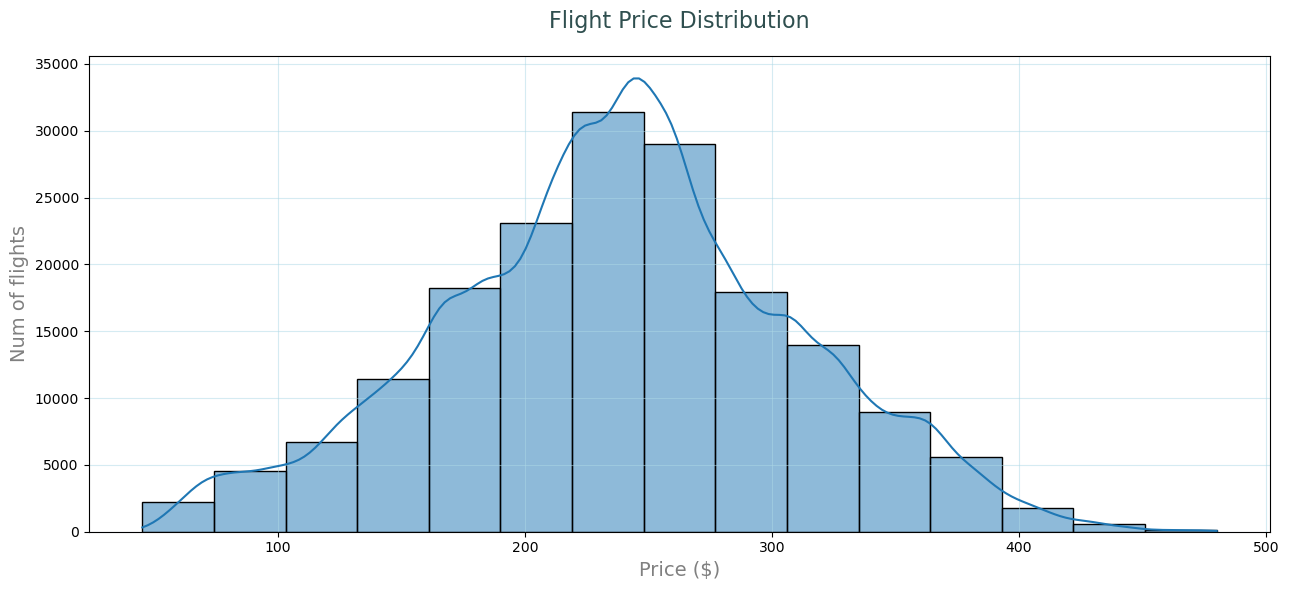

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(13, 6))
sns.histplot(cleaned_df['Price'], bins=15, kde=True)
plt.title('Flight Price Distribution', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Price ($)', fontsize=14, color='gray')
plt.ylabel('Num of flights', fontsize=14, color='gray')
plt.grid(True, linestyle='-', color='lightblue', alpha=0.5)
plt.tight_layout()
plt.show()


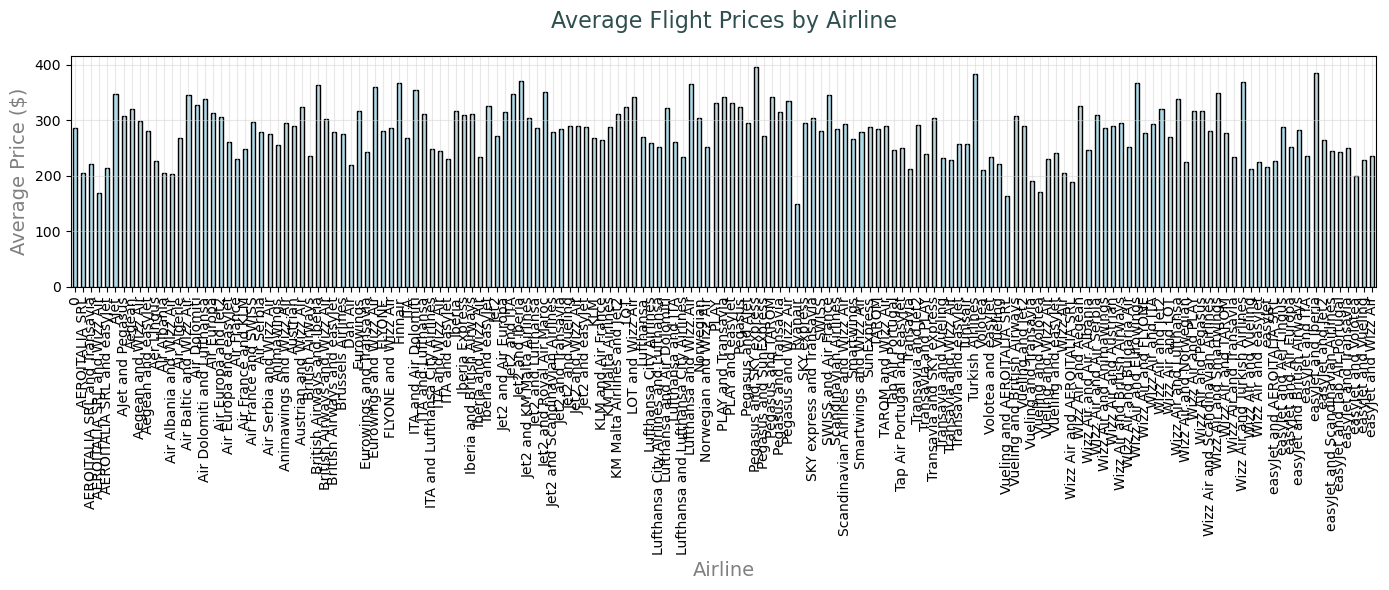

In [57]:
avg_prices = cleaned_df.groupby('Airline')['Price'].mean()
plt.figure(figsize=(14, 6))
avg_prices.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Average Flight Prices by Airline', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Airline', fontsize=14, color='gray')
plt.ylabel('Average Price ($)', fontsize=14, color='gray')
plt.grid(True, linestyle='-', color='lightgray', alpha=0.5)
plt.tight_layout()
plt.show()

In [45]:
# count_zeros = (df['Airline'] == "0").sum()
# df = df[df['Airline'] != "0"]

# # Save the cleaned data to a new CSV file
# df.to_csv("cleaned_flight_data.csv", index=False)

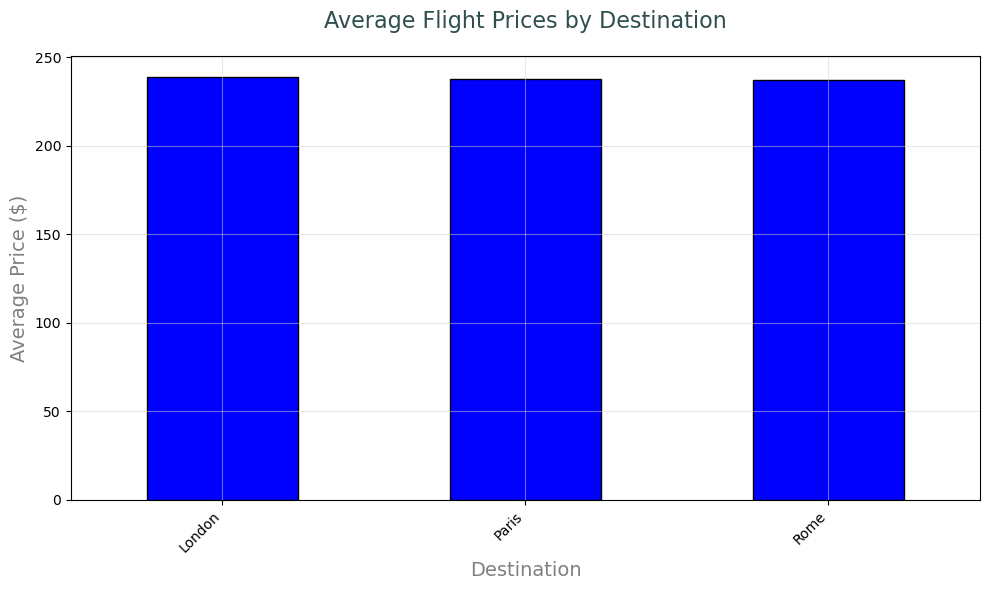

In [58]:

avg_prices_by_destination = cleaned_df.groupby('Destination')['Price'].mean()
plt.figure(figsize=(10, 6))
avg_prices_by_destination.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Average Flight Prices by Destination', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Destination', fontsize=14, color='gray')
plt.ylabel('Average Price ($)', fontsize=14, color='gray')
plt.grid(True, linestyle='-', color='lightgray', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_57536/4179202261.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

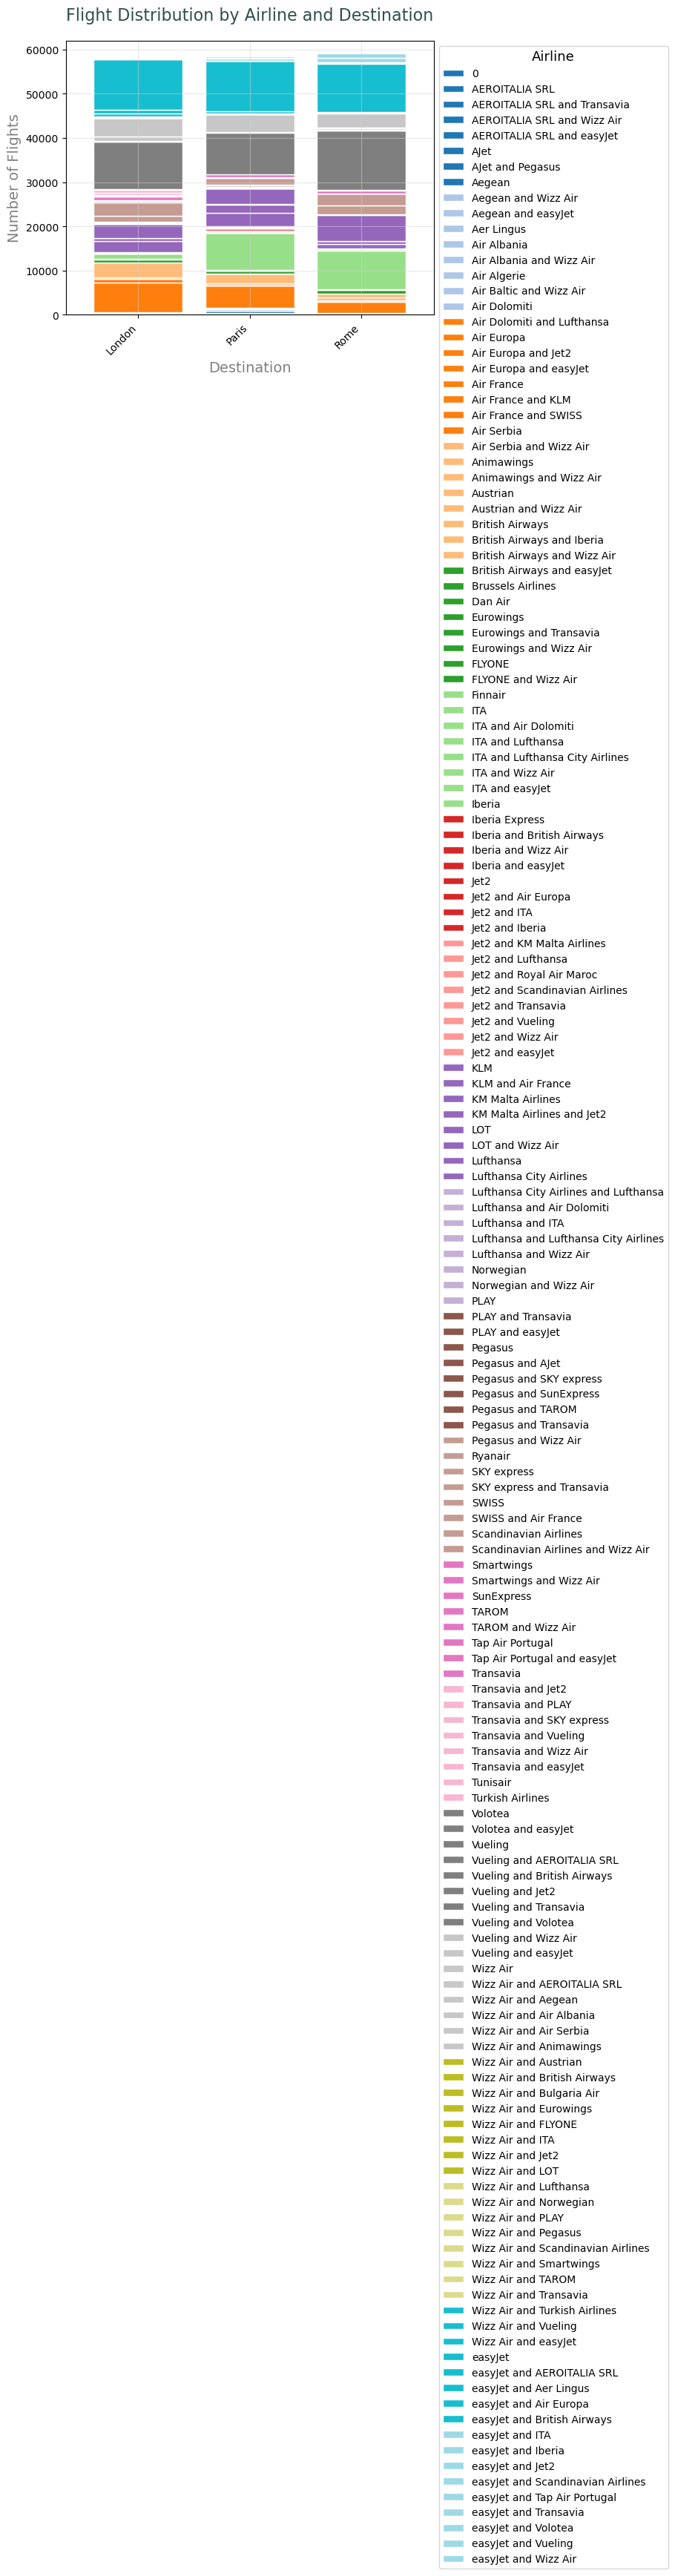

In [59]:
flight_counts = cleaned_df.groupby(['Destination', 'Airline']).size().unstack()
plt.figure(figsize=(10, 6))
flight_counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='white', width=0.8)
plt.title('Flight Distribution by Airline and Destination', fontsize=16, color='darkslategray', pad=20)
plt.xlabel('Destination', fontsize=14, color='gray')
plt.ylabel('Number of Flights', fontsize=14, color='gray')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='-', color='lightgray', alpha=0.5)
plt.legend(title='Airline', title_fontsize='13', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_57536/3684078339.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_unclean, x='Destination', y='Layover', palette='coolwarm')
/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_57536/3684078339.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Destination', y='Duration', palette='viridis')


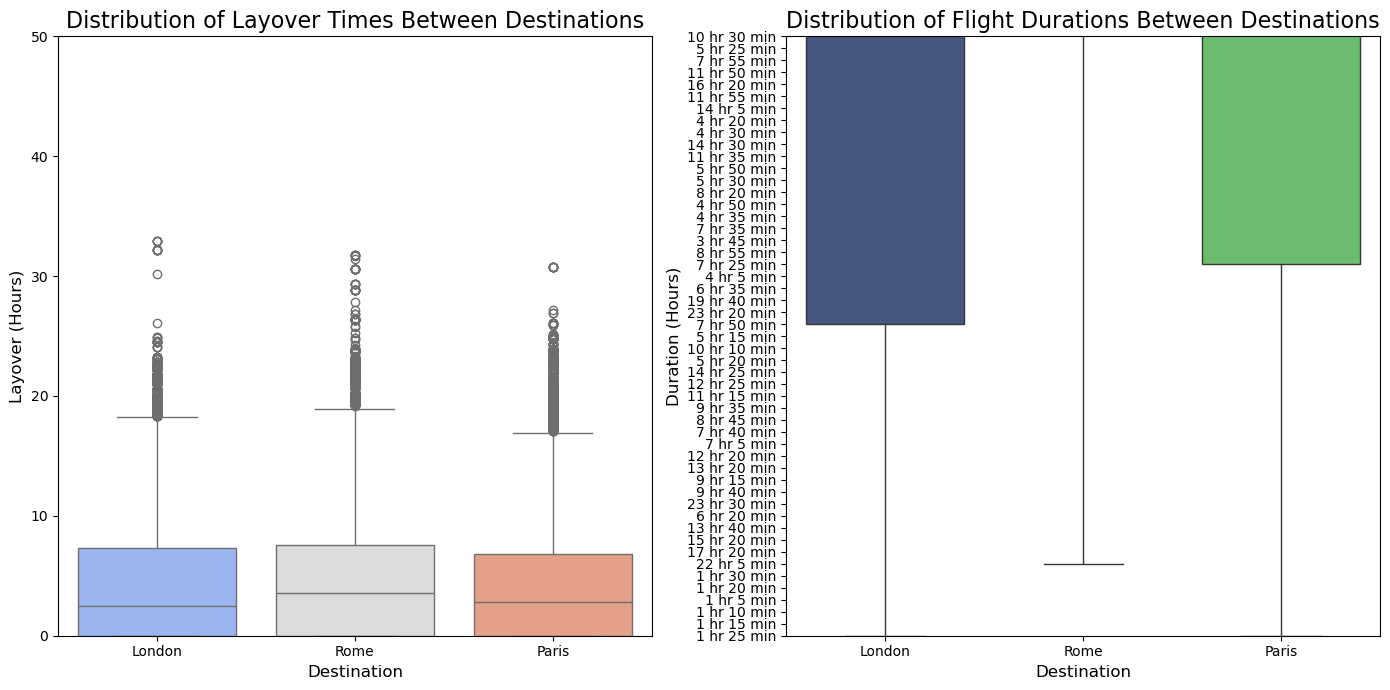

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.boxplot(data=cleaned_df, x='Destination', y='Layover', palette='coolwarm')
plt.title('Distribution of Layover Times Between Destinations', fontsize=16)
plt.xlabel('Destination', fontsize=12)
plt.ylabel('Layover (Hours)', fontsize=12)
plt.ylim(0, 50)  
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Destination', y='Duration', palette='viridis')
plt.title('Distribution of Flight Durations Between Destinations', fontsize=16)
plt.xlabel('Destination', fontsize=12)
plt.ylabel('Duration (Hours)', fontsize=12)
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

/var/folders/zf/19jqyvhn69bbb4rbtcy5xnw00000gn/T/ipykernel_97696/3013770038.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_df, x='Departure Airport', y='Price', palette='coolwarm')


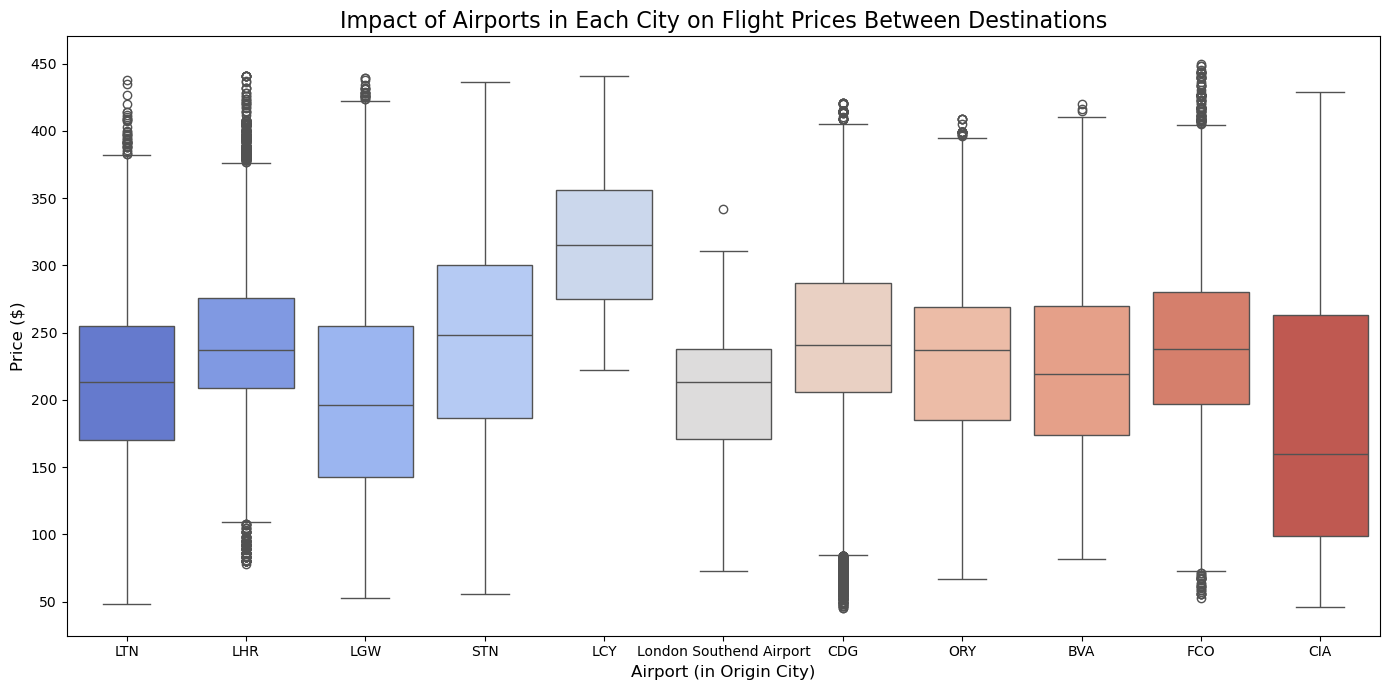

In [230]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=cleaned_df, x='Departure Airport', y='Price', palette='coolwarm')
plt.title('Impact of Airports in Each City on Flight Prices Between Destinations', fontsize=16)
plt.xlabel('Airport (in Origin City)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.tight_layout()
plt.show()

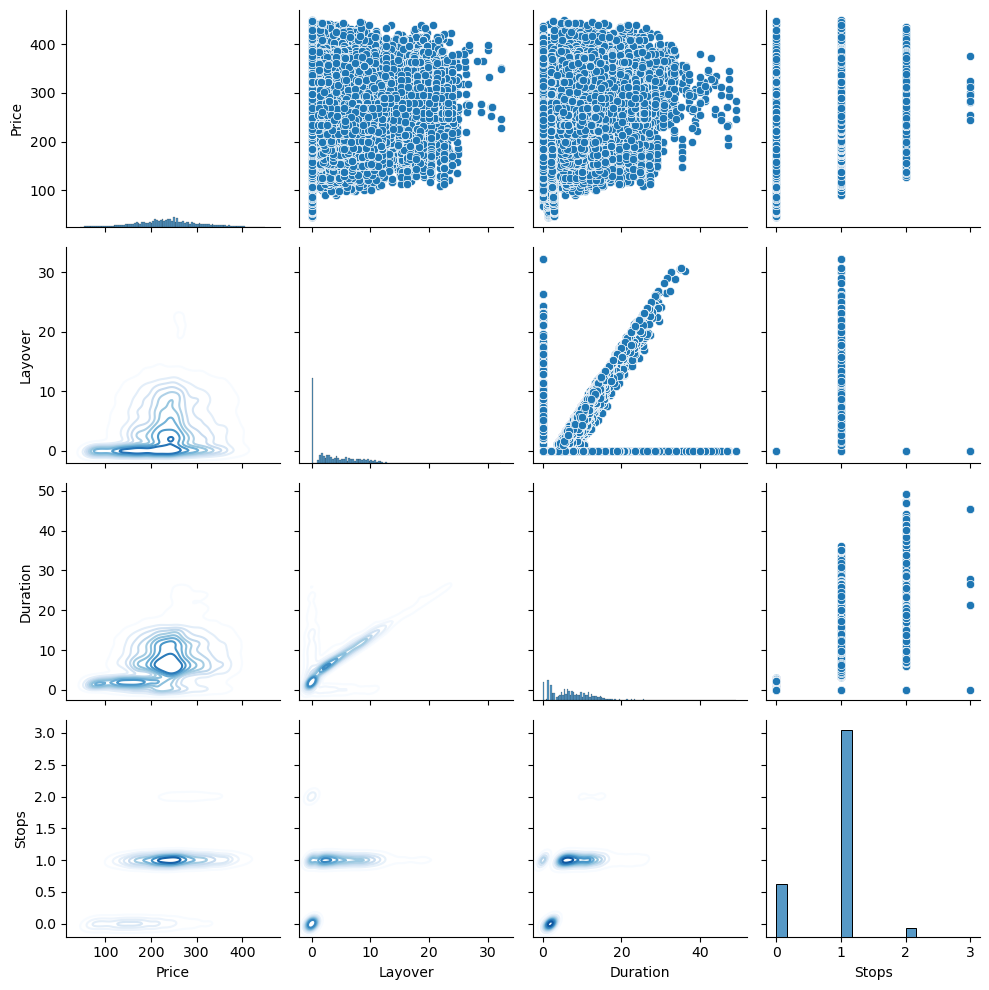

In [233]:
cleaned_df['Price'] = pd.to_numeric(cleaned_df['Price'], errors='coerce')
cleaned_df['Layover'] = pd.to_numeric(cleaned_df['Layover'], errors='coerce')
cleaned_df['Duration'] = pd.to_numeric(cleaned_df['Duration'], errors='coerce')
cleaned_df['Stops'] = pd.to_numeric(cleaned_df['Stops'], errors='coerce')

numeric_vars = ['Price', 'Layover', 'Duration', 'Stops']

# Create PairGrid for numeric variables only
g = sns.PairGrid(cleaned_df, vars=numeric_vars, height=2.5)

# Display relationships with scatter plots for the upper triangle
g.map_upper(sns.scatterplot)

# Display density estimation with KDE for the lower triangle (only numeric variables)
g.map_lower(sns.kdeplot, cmap="Blues")

# Display histograms on the diagonal
g.map_diag(sns.histplot, kde_kws={'color': 'black'})

# Display the grid
plt.tight_layout()
plt.show()

In [ ]:
# import pandas as pd

# # Load both CSV files
# df1 = pd.read_csv("/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/flight_prices_kayak03032511.csv")
# df2 = pd.read_csv("/Users/nadavcohen/Desktop/data science project 25/data-science-flights-project/flight_prices_kayak030325.csv")

# # Concatenate them row-wise
# df_merged = pd.concat([df1, df2], ignore_index=True)

# # Save to a new CSV file
# df_merged.to_csv("KayakFLIGHTMERGE0304.csv", index=False)

# print("Merged CSV file has been saved as 'merged_file")

Merged CSV file has been saved as 'merged_file
